# Sparse GP Regression on Molecules #

An example notebook for sparse GP regression to enable scalability to large molecular datasests.


In [2]:
# Imports

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

# To import from the gauche package
import sys
sys.path.append('..')

import time

from botorch import fit_gpytorch_model
import gpytorch
from mordred import Calculator, descriptors
import numpy as np
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch

from gauche.dataloader import DataLoaderMP
from gauche.dataloader.data_utils import transform_data

In [16]:
# We define our sparse GP model using and inducing point kernel wrapped around the RQ kernel

from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, InducingPointKernel, RQKernel
from gpytorch.distributions import MultivariateNormal

class SparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SparseGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RQKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:100, :].clone(), likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

## Sparse GP Regression on the Lipophilicity Dataset ##

We define our experiment parameters. In this case we are working on the large lipophilicity dataset [1] containing 4200 molecules.

In [8]:
# Regression experiments parameters, number of random splits and split size

n_trials = 20
test_set_size = 0.2

Load the Lipophilicity Dataset via the DataLoaderMP class which contains several molecular property prediction benchmark datasets!

In [17]:
# Load the Lipophilicity dataset

loader = DataLoaderMP()
loader.load_benchmark("Lipophilicity", "../data/property_prediction/lipophilicity.csv")

# Mordred descriptor computation is expensive
calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in loader.features]
t0 = time.time()
X_mordred = [calc(mol) for mol in mols]
t1 = time.time()
print(f'Mordred descriptor computation takes {t1 - t0} seconds')
X_mordred = np.array(X_mordred).astype(np.float64)

"""Collect nan indices"""

nan_dims = []

for i in range(len(X_mordred)):
    nan_indices = list(np.where(np.isnan(X_mordred[i, :]))[0])
    for dim in nan_indices:
        if dim not in nan_dims:
            nan_dims.append(dim)
            
X_mordred = np.delete(X_mordred, nan_dims, axis=1)

Mordred descriptor computation takes 1407.325366973877 seconds


## Model Evaluation ##

Here we define a training/evaluation loop assessing performance using the root mean-square error (RMSE), mean average error (MAE), and $R^2$ metrics. The `evaluate_model` function also computes the GP confidence-error curve which will be explained below.

In [18]:
import warnings
warnings.filterwarnings("ignore") # Turn off GPyTorch warnings

from matplotlib import pyplot as plt
%matplotlib inline


def evaluate_model(X, y):
    """Helper function for model evaluation.
    
    Args:
        X: n x d NumPy array of inputs representing molecules
        y: n x 1 NumPy array of output labels
    Returns:
        regression metrics and confidence-error curve plot.
    """

    # initialise performance metric lists
    r2_list = []
    rmse_list = []
    mae_list = []
    
    # We pre-allocate array for plotting confidence-error curves

    _, _, _, y_test = train_test_split(X, y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)

    mae_confidence_list = np.zeros((n_trials, n_test))
    
    print('\nBeginning training loop...')

    for i in range(0, n_trials):
        
        print(f'Starting trial {i}')
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        pca_mordred = PCA(n_components=51)
        X_train = pca_mordred.fit_transform(X_train)
        X_test = pca_mordred.transform(X_test)

        #  We standardise the outputs
        _, y_train, _, y_test, y_scaler = transform_data(X_train, y_train, X_test, y_test)

        # Convert numpy arrays to PyTorch tensors and flatten the label vectors
        X_train = torch.tensor(X_train.astype(np.float64))
        X_test = torch.tensor(X_test.astype(np.float64))
        y_train = torch.tensor(y_train).flatten()
        y_test = torch.tensor(y_test).flatten()

        # initialise GP likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = SparseGPModel(X_train, y_train, likelihood)

        # Find optimal model hyperparameters
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        # Use the BoTorch utility for fitting GPs in order to use the LBFGS-B optimiser (recommended)
        fit_gpytorch_model(mll)

        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()

        # mean and variance GP prediction
        f_pred = model(X_test)

        y_pred = f_pred.mean
        y_var = f_pred.variance

        # Transform back to real data space to compute metrics and detach gradients. Must unsqueeze dimension
        # to make compatible with inverse_transform in scikit-learn version > 1
        y_pred = y_scaler.inverse_transform(y_pred.detach().unsqueeze(dim=1))
        y_test = y_scaler.inverse_transform(y_test.detach().unsqueeze(dim=1))
        
        # Compute scores for confidence curve plotting.

        ranked_confidence_list = np.argsort(y_var.detach(), axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence

            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Output Standardised RMSE and RMSE on Train Set
        y_train = y_train.detach()
        y_pred_train = model(X_train).mean.detach()
        train_rmse_stan = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_rmse = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train.unsqueeze(dim=1)), 
                                                y_scaler.inverse_transform(y_pred_train.unsqueeze(dim=1))))

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)
        
    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)
        
    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list)))) 
    
    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))  

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std

    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('MAE (nm)')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    plt.yticks(np.arange(0, np.max(upper) + 1, 5.0))
    plt.show()
    
    return rmse_list, mae_list
    

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


Check the perfomance achieved by our sparse GP model.


Beginning training loop...
Starting trial 0
Starting trial 1
Starting trial 2
Starting trial 3
Starting trial 4
Starting trial 5
Starting trial 6
Starting trial 7
Starting trial 8
Starting trial 9
Starting trial 10
Starting trial 11
Starting trial 12
Starting trial 13
Starting trial 14
Starting trial 15
Starting trial 16
Starting trial 17
Starting trial 18
Starting trial 19

mean R^2: 0.3715 +- 0.0443
mean RMSE: 0.9370 +- 0.0299
mean MAE: 0.7444 +- 0.0255



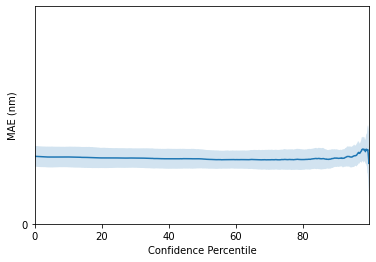

In [21]:
rmse_mordred, mae_mordred = evaluate_model(X_mordred, y)

## References 

[1] Anna Gaulton, Louisa J Bellis, A Patricia Bento, Jon Chambers, Mark Davies, Anne Hersey,
Yvonne Light, Shaun McGlinchey, David Michalovich, Bissan Al-Lazikani, et al. [ChEMBL:
A large-scale bioactivity database for drug discovery](https://pubmed.ncbi.nlm.nih.gov/21948594/). Nucleic Acids Research, 2012.

[2] Bajusz, D., Rácz, A. and Héberger, K., 2015. [Why is Tanimoto index an appropriate choice for fingerprint-based similarity calculations?. Journal of cheminformatics](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3), 7(1), pp.1-13.